# 8.1 Comparison between reconstucted terms of ERA5 and SD transects. 


Packages

In [1]:
import pathlib
from pathlib import Path
import os 

import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import gsw
import cmocean as cmo
import scipy
from scipy import stats
import netCDF4
from netCDF4 import Dataset as nc
import cartopy.crs as ccrs
import matplotlib
import seaborn as sns

from AirSeaFluxCode import AirSeaFluxCode

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
import math

font = {'weight' : 'normal',
        'size'  : 20}
matplotlib.rc('font', **font)

Functions

In [2]:
import math
def wind_sp_kt_to_ms(wind_kts):
    
    return wind_kts*0.514444  #kt to m/s

def wind_sp_to_10m(wind_sp, z0=1.52e-4, zm=3.4, z10=10):
    
    """Correct wind speed data from a given height to 10m above sea level.

       wind_sp = wind speed measurement (m/s)
       z0      = roughness length
       zm      = height of wind measurement
       z10     = height to correct to
    """
    
    return wind_sp*(math.log(z10/z0)/math.log(zm/z0))

def wind_direction(v, u):
    DIR=90-np.rad2deg(np.arctan(v / u) )
    return DIR

from tqdm import tqdm  # Assuming you're using the tqdm library for progress tracking

def colocate_era5_sd(sd, era5, var):
    """
    Colocates ERA5 data with Shipboard Data (SD) based on time, latitude, and longitude.

    Args:
    - sd (xarray.Dataset): Shipboard Data with time, longitude, and latitude dimensions.
    - era5 (xarray.Dataset): ERA5 data with time, longitude, and latitude dimensions.
    - var (str): The variable to be colocated.

    Returns:
    - era5_var (numpy.ndarray): An array of ERA5 variable values colocated with SD.
    """

    # Initialize an empty array to store ERA5 variable values
    era5_var = np.ndarray(sd.time.size)

    # Iterate through each time step in Shipboard Data (SD)
    for t in tqdm(range(sd.time.size)):

        # Find the matching time index in ERA5 data
        idx = sd.time[t] == era5.time

        # Find the latitude and longitude indices in ERA5 data that are closest to SD coordinates
        lon_idx = np.argmin(np.abs(sd.longitude.data[t] - era5.longitude.data))
        lat_idx = np.argmin(np.abs(sd.latitude.data[t] - era5.latitude.data))

        # Extract and store the ERA5 variable value for the matching time and location
        era5_var[t] = era5[var].isel(time=idx, latitude=lat_idx, longitude=lon_idx).data

    return era5_var

def era5dewtorh(era5_ds):
    # Extract dew point temperature (Dp) values from the input dataset
    Dp = era5_ds.d2m.values # dew point temperature in °C

    # Extract air temperature (T) values from the input dataset
    T = era5_ds.t2m.values # temperature in °C
    
    # Calculate relative humidity (RH) using the formula and add it to the input dataset
    era5_ds['rh'] = (('time', 'latitude', 'longitude'),
                     100 * (np.exp((17.625 * Dp) / (243.04 + Dp)) / np.exp((17.625 * T) / (243.04 + T))))
    
    # Return the input dataset with the 'rh' variable added
    return era5_ds

def dist_era5_sd(sd, era5):
    """
    Colocates ERA5 data with Shipboard Data (SD) based on time, latitude, and longitude.

    Args:
    - sd (xarray.Dataset): Shipboard Data with time, longitude, and latitude dimensions.
    - era5 (xarray.Dataset): ERA5 data with time, longitude, and latitude dimensions.

    Returns:
    - dist (numpy.ndarray): An array of distance in meters between nearest ERA5 gridpoint and SD.
    """

    # Initialize an empty array to store ERA5 variable values
    dist = np.ndarray(sd.time.size)
    #time = np.ndarray(sd.time.size)
    # Iterate through each time step in Shipboard Data (SD)
    for t in tqdm(range(sd.time.size)):

        # Find the matching time index in ERA5 data
        idx = sd.time[t] == era5.time

        # Find the latitude and longitude indices in ERA5 data that are closest to SD coordinates
        lon_idx = np.argmin(np.abs(sd.longitude.data[t] - era5.longitude.data))
        lat_idx = np.argmin(np.abs(sd.latitude.data[t] - era5.latitude.data))

        # Extract and store the ERA5 variable value for the matching time and location
        dist[t] = gsw.distance([era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['longitude'].data, sd.longitude[t]],[era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['latitude'].data, sd.latitude[t]]) 
        
        #dist[t]= (((era5.latitude[lat_idx]-sd.latitude[lat_idx])**2)+((era5.longitude[lon_idx]-sd.longitude[lon_idx])**2))**0.5
        #time[t] = era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['time']
        
        
    return dist

Load datasets

In [3]:
ds=xr.open_dataset( pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ds.nc')
ERA5=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/ERA5file.nc')
coloc3=pd.read_csv(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/coloc3.csv') #open coloc3
dsadcpH=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/dsadcpH.nc')
ostia=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/ostia.nc')
ostia_regrid=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ostia_regrid.nc')
ERA5big=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5big.nc')

ERA5big=ERA5big.rename({'msdwlwrf':'dwlw'})
ERA5big=ERA5big.rename({'msdwswrf':'dwsw'})
ERA5big['t2m']=ERA5big.t2m-273.15
ERA5big['d2m']=ERA5big.d2m-273.15
ERA5big['WIND_CORR10']=(ERA5big.u10**2+ERA5big.v10**2)**0.5
ERA5big=ERA5big.sel(time=(( ERA5big.time>=dsadcpH.time.min()) & (ERA5big.time<=dsadcpH.time.max()) ))

ERA5big=era5dewtorh(ERA5big)

rec_ERA5_ostia=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5_ostia_sst_rec.csv').to_xarray() #reconstructed terms ERA5 w ostia sst
rec_ERA5=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5_rec.csv').to_xarray() #reconstructed terms ERA5
rec_SD=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/SD-rec-THF.csv').to_xarray() #reconstructed terms SD

ASFC_ERA5_ostia=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5_ostia_sst_ASFC.csv') #ASFC output ERA5 (coloc3) w ostia sst
ASFC_ERA5=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5_ASFC.csv') #ASFC output ERA5 (coloc3)
ASFC_SD=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/SD-ASFC.csv') #ASFC output SD

Correlation plots between SD and ERA5 reconstructed terms.

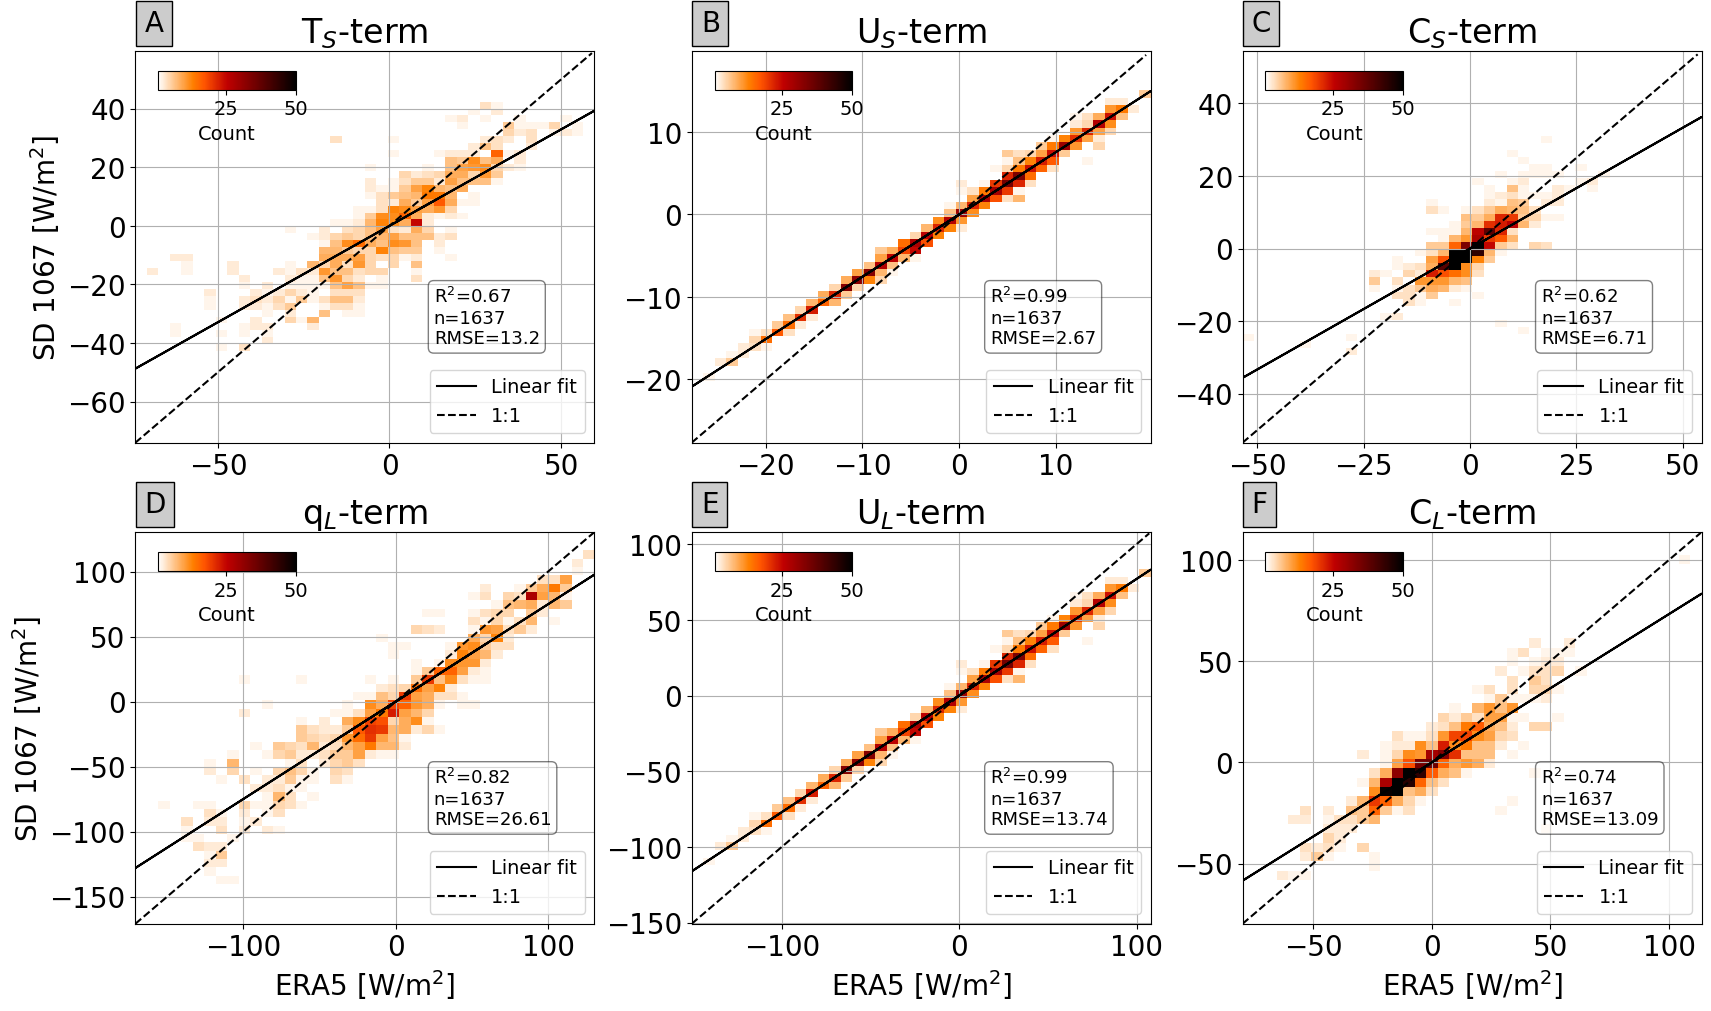

In [4]:
fig, ax=plt.subplots(2,3, figsize=[17,10], constrained_layout=True)

s_terms=['t_term', 'u_term_t', 'cov_term_t']
l_terms=['q_term', 'u_term_q', 'cov_term_q']

labelS = ['T$_S$-term', 'U$_S$-term', 'C$_S$-term']
labelL = ['q$_L$-term', 'U$_L$-term', 'C$_L$-term']

fig_label=[['A','B','C'],['D','E','F']]

bbox = dict(boxstyle="square", fc="0.8")

ticksize=14

text_x=0.02
text_y=1.05

for i in np.arange(3):
    msk=np.isfinite(rec_SD[s_terms[i]])
    
    x= rec_ERA5.shf_coeffs*rec_ERA5[s_terms[i]].sel(index=msk)
    y= rec_SD.shf_coeffs*rec_SD[s_terms[i]].sel(index=msk)
    wind1=ax[0,i].hist2d(x, y, bins=40, cmin=1,cmap='gist_heat_r', vmax=50)
    #ax[0,i].scatter(x, y) #Idea is to color by wind, then we can see if there is issues at high or low windspeeds
    cax = ax[0,i].inset_axes([0.05, 0.9, 0.3, 0.05])
    cbar=fig.colorbar(wind1[3], cax=cax, label=('Count'), orientation='horizontal')
    #Create linear fit line and plot
    cbar.ax.tick_params(labelsize=ticksize)
    cbar.set_label(label='Count', size=ticksize)
#cax = ax[0,i].inset_axes([0.3, 0.07, 0.4, 0.04])
#fig.colorbar(pcm, cax=cax, orientation='horizontal')

    ax[0,i].set_xlim(x.min(), x.max())
    ax[0,i].set_ylim(x.min(), x.max())

    ax[0,i].annotate(fig_label[0][i], xy=(text_x, text_y), xycoords='axes fraction', bbox=bbox)
    
    #obtain m (slope) and b(intercept) of linear regression line
    m, b = np.polyfit(x, y, 1)
    
    #add linear regression line to scatterplot 
    ax[0,i].plot(x, m*x+b, color='k', label='Linear fit')
    ax[0,i].plot(np.arange(x.min(), x.max(), 1), np.arange(x.min(), x.max(), 1) , linestyle='--', color='k', label=('1:1'))
    #Create stats and statbox
    RMSE = math.sqrt(mean_squared_error(x, y))
    
    r2=scipy.stats.linregress(x, y).rvalue**2
    n = len(x)
    #p= scipy.stats.linregress(coloc3msk[colocno[i]], dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]]))).pvalue
    
    textstr= 'R$^2$='+ str(round(r2, 2)) + '\n'+ 'n=' +str(n) + '\n' + 'RMSE='+ str(round(RMSE,2)) 
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax[0,i].annotate(textstr, xy=(0.65, 0.4), xycoords='axes fraction', bbox=props, va='top',fontsize=13)

    msk=np.isfinite(rec_SD[l_terms[i]])
    
    x= rec_ERA5.lhf_coeffs*rec_ERA5[l_terms[i]].sel(index=msk)
    y= rec_SD.lhf_coeffs*rec_SD[l_terms[i]].sel(index=msk)
    
    
    #ax[1,i].scatter(x, y)
    wind2= ax[1,i].hist2d(x, y, bins=40, cmin=1, label=labelL[i],cmap='gist_heat_r', vmax=50)
    cax = ax[1,i].inset_axes([0.05, 0.9, 0.3, 0.05])
    
    cbar=fig.colorbar(wind2[3], cax=cax, label=('Count'), orientation='horizontal')
    cbar.ax.tick_params(labelsize=ticksize)
    
    cbar.set_label(label='Count', size=ticksize)
    #cbar.set_fontsize(20)
    
    m, b = np.polyfit(x, y, 1)
    
    #add linear regression line to scatterplot 
    ax[1,i].plot(x, m*x+b, color='k', label='Linear fit')
    ax[1,i].plot(np.arange(x.min(), x.max(), 1), np.arange(x.min(), x.max(), 1) , linestyle='--', color='k', label=('1:1'))
    #Create stats and statbox
    RMSE = math.sqrt(mean_squared_error(x, y))
    
    r2=scipy.stats.linregress(x, y).rvalue**2
    n = len(x)
    #p= scipy.stats.linregress(coloc3msk[colocno[i]], dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]]))).pvalue
    
    textstr='R$^2$='+ str(round(r2, 2)) + '\n'+ 'n=' +str(n) + '\n' + 'RMSE='+ str(round(RMSE,2)) 
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    


    ax[1,i].annotate(textstr, xy=(0.65, 0.4), xycoords='axes fraction', bbox=props, va='top',fontsize=13)
    ax[1,i].annotate(fig_label[1][i], xy=(text_x, text_y), xycoords='axes fraction', bbox=bbox)
#    ax[0,i].set_title('Q$_S´$')
#    ax[1,i].set_title('Q$_L´$')
    
    ax[0,i].set_title(labelS[i])    
    ax[1,i].set_title(labelL[i])

    
    ax[0,i].grid()
    ax[1,i].grid()
    
    ax[0,i].legend(loc='lower right', fontsize='x-small')
    ax[1,i].legend(loc='lower right', fontsize='x-small')

    ax[1,i].set_xlim(x.min(), x.max())
    ax[1,i].set_ylim(x.min(), x.max())
#    mask = ~np.isnan(varprime.Qs) & ~np.isnan(varprime.deltaT)

#    scipy.stats.linregress(varprime.Qs[mask], varprime.deltaT[mask])

ax[0,0].set_ylabel('SD 1067 [W/m$^2$]')
ax[1,0].set_ylabel('SD 1067 [W/m$^2$]')

ax[1,0].set_xlabel('ERA5 [W/m$^2$]')
ax[1,1].set_xlabel('ERA5 [W/m$^2$]')
ax[1,2].set_xlabel('ERA5 [W/m$^2$]')

    
plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/final_figs/ERA5-SD-.png')

## OSTIA sst comparison

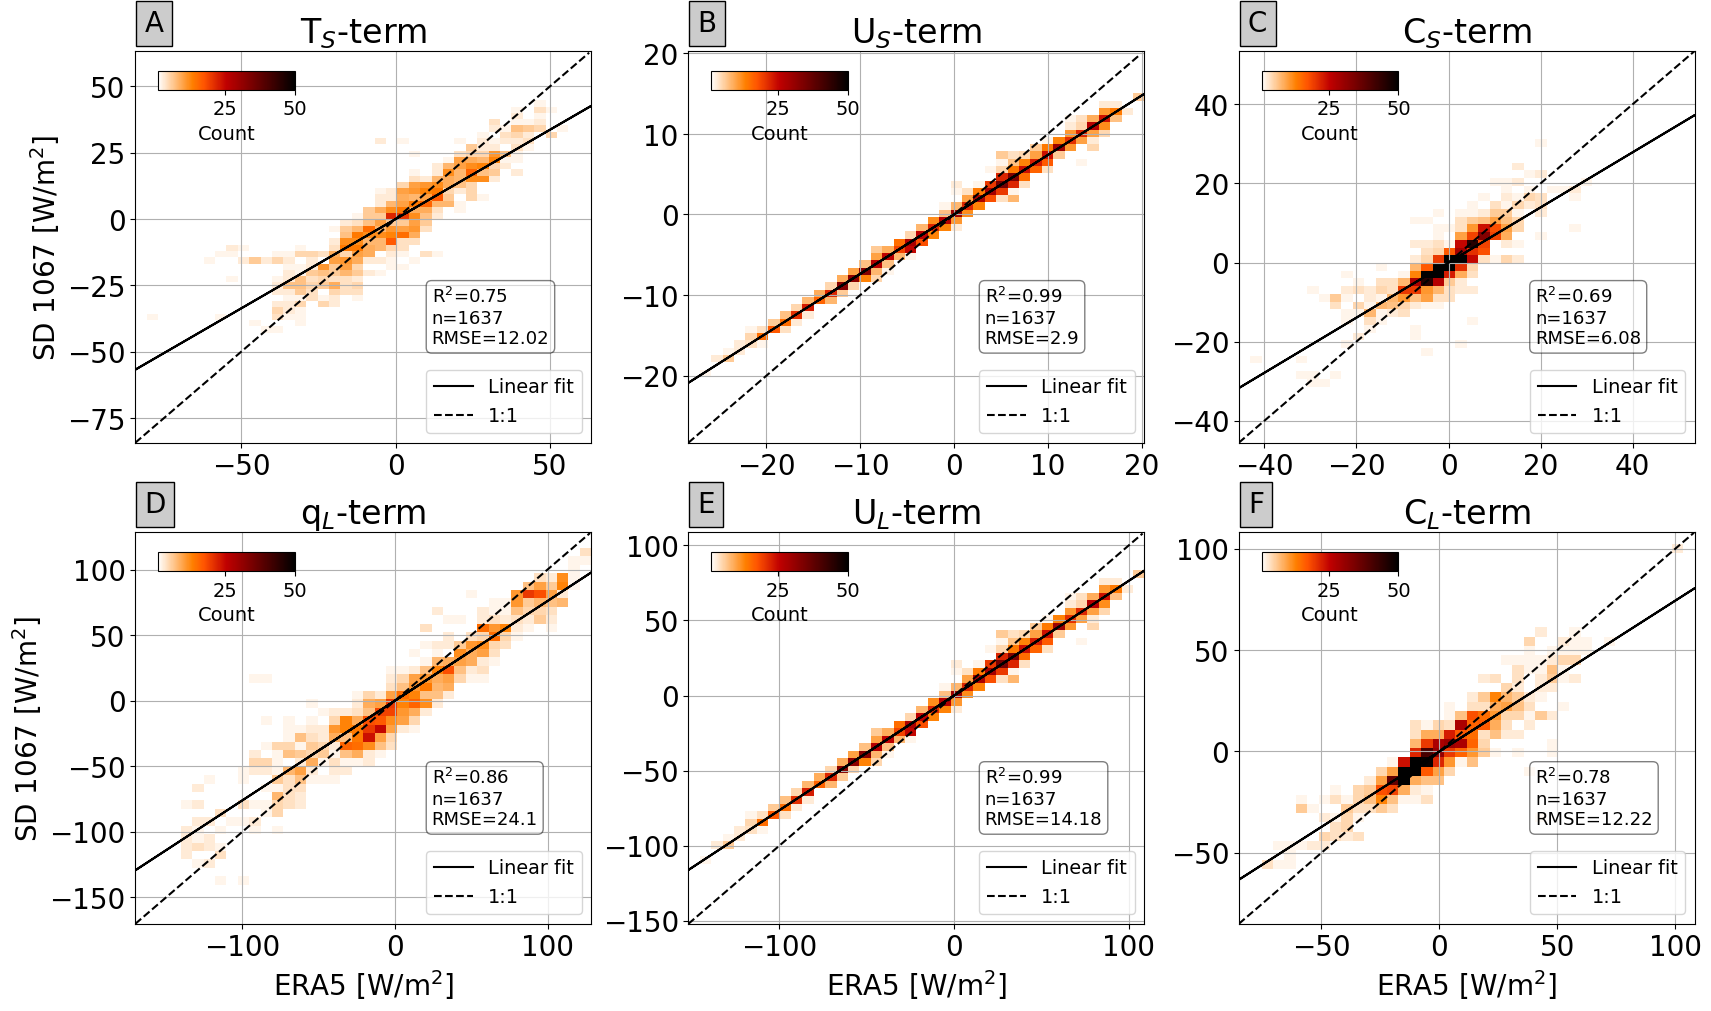

In [17]:
fig, ax=plt.subplots(2,3, figsize=[17,10], constrained_layout=True)

s_terms=['t_term', 'u_term_t', 'cov_term_t']
l_terms=['q_term', 'u_term_q', 'cov_term_q']

labelS = ['T$_S$-term', 'U$_S$-term', 'C$_S$-term']
labelL = ['q$_L$-term', 'U$_L$-term', 'C$_L$-term']

fig_label=[['A','B','C'],['D','E','F']]

bbox = dict(boxstyle="square", fc="0.8")

ticksize=14


text_x=0.02
text_y=1.05

for i in np.arange(3):
    msk=np.isfinite(rec_SD[s_terms[i]])
    
    x= rec_ERA5_ostia.shf_coeffs*rec_ERA5_ostia[s_terms[i]].sel(index=msk)
    y= rec_SD.shf_coeffs*rec_SD[s_terms[i]].sel(index=msk)
    wind1=ax[0,i].hist2d(x, y, bins=40, cmin=1,cmap='gist_heat_r', vmax=50)
    #ax[0,i].scatter(x, y) #Idea is to color by wind, then we can see if there is issues at high or low windspeeds
    cax = ax[0,i].inset_axes([0.05, 0.9, 0.3, 0.05])
    cbar=fig.colorbar(wind1[3], cax=cax, label=('Count'), orientation='horizontal')
    #Create linear fit line and plot
    cbar.ax.tick_params(labelsize=ticksize)
    cbar.set_label(label='Count', size=ticksize)
#cax = ax[0,i].inset_axes([0.3, 0.07, 0.4, 0.04])
#fig.colorbar(pcm, cax=cax, orientation='horizontal')

    ax[0,i].set_xlim(x.min(), x.max())
    ax[0,i].set_ylim(x.min(), x.max())

    ax[0,i].annotate(fig_label[0][i], xy=(text_x, text_y), xycoords='axes fraction', bbox=bbox)
    
    #obtain m (slope) and b(intercept) of linear regression line
    m, b = np.polyfit(x, y, 1)
    
    #add linear regression line to scatterplot 
    ax[0,i].plot(x, m*x+b, color='k', label='Linear fit')
    ax[0,i].plot(np.arange(x.min(), x.max(), 1), np.arange(x.min(), x.max(), 1) , linestyle='--', color='k', label=('1:1'))
    #Create stats and statbox
    RMSE = math.sqrt(mean_squared_error(x, y))
    
    r2=scipy.stats.linregress(x, y).rvalue**2
    n = len(x)
    #p= scipy.stats.linregress(coloc3msk[colocno[i]], dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]]))).pvalue
    
    textstr= 'R$^2$='+ str(round(r2, 2)) + '\n'+ 'n=' +str(n) + '\n' + 'RMSE='+ str(round(RMSE,2)) 
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax[0,i].annotate(textstr, xy=(0.65, 0.4), xycoords='axes fraction', bbox=props, va='top',fontsize=13)

    msk=np.isfinite(rec_SD[l_terms[i]])
    
    x= rec_ERA5_ostia.lhf_coeffs*rec_ERA5_ostia[l_terms[i]].sel(index=msk)
    y= rec_SD.lhf_coeffs*rec_SD[l_terms[i]].sel(index=msk)
    
    
    #ax[1,i].scatter(x, y)
    wind2= ax[1,i].hist2d(x, y, bins=40, cmin=1, label=labelL[i],cmap='gist_heat_r', vmax=50)
    cax = ax[1,i].inset_axes([0.05, 0.9, 0.3, 0.05])
    
    cbar=fig.colorbar(wind2[3], cax=cax, label=('Count'), orientation='horizontal')
    cbar.ax.tick_params(labelsize=ticksize)
    
    cbar.set_label(label='Count', size=ticksize)
    #cbar.set_fontsize(20)
    
    m, b = np.polyfit(x, y, 1)
    
    #add linear regression line to scatterplot 
    ax[1,i].plot(x, m*x+b, color='k', label='Linear fit')
    ax[1,i].plot(np.arange(x.min(), x.max(), 1), np.arange(x.min(), x.max(), 1) , linestyle='--', color='k', label=('1:1'))
    #Create stats and statbox
    RMSE = math.sqrt(mean_squared_error(x, y))
    
    r2=scipy.stats.linregress(x, y).rvalue**2
    n = len(x)
    #p= scipy.stats.linregress(coloc3msk[colocno[i]], dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]]))).pvalue
    
    textstr='R$^2$='+ str(round(r2, 2)) + '\n'+ 'n=' +str(n) + '\n' + 'RMSE='+ str(round(RMSE,2)) 
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    


    ax[1,i].annotate(textstr, xy=(0.65, 0.4), xycoords='axes fraction', bbox=props, va='top',fontsize=13)
    ax[1,i].annotate(fig_label[1][i], xy=(text_x, text_y), xycoords='axes fraction', bbox=bbox)
#    ax[0,i].set_title('Q$_S´$')
#    ax[1,i].set_title('Q$_L´$')
    
    ax[0,i].set_title(labelS[i])    
    ax[1,i].set_title(labelL[i])

    
    ax[0,i].grid()
    ax[1,i].grid()
    
    ax[0,i].legend(loc='lower right', fontsize='x-small')
    ax[1,i].legend(loc='lower right', fontsize='x-small')

    ax[1,i].set_xlim(x.min(), x.max())
    ax[1,i].set_ylim(x.min(), x.max())
#    mask = ~np.isnan(varprime.Qs) & ~np.isnan(varprime.deltaT)

#    scipy.stats.linregress(varprime.Qs[mask], varprime.deltaT[mask])

ax[0,0].set_ylabel('SD 1067 [W/m$^2$]')
ax[1,0].set_ylabel('SD 1067 [W/m$^2$]')

ax[1,0].set_xlabel('ERA5 [W/m$^2$]')
ax[1,1].set_xlabel('ERA5 [W/m$^2$]')
ax[1,2].set_xlabel('ERA5 [W/m$^2$]')

    
plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/final_figs/ERA5-ostia-SD-.png')

In [5]:
ERA5_ASFC=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5_ASFC.csv')
SD_ASFC=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/SD-ASFC.csv')
coloc4=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/coloc4.csv')

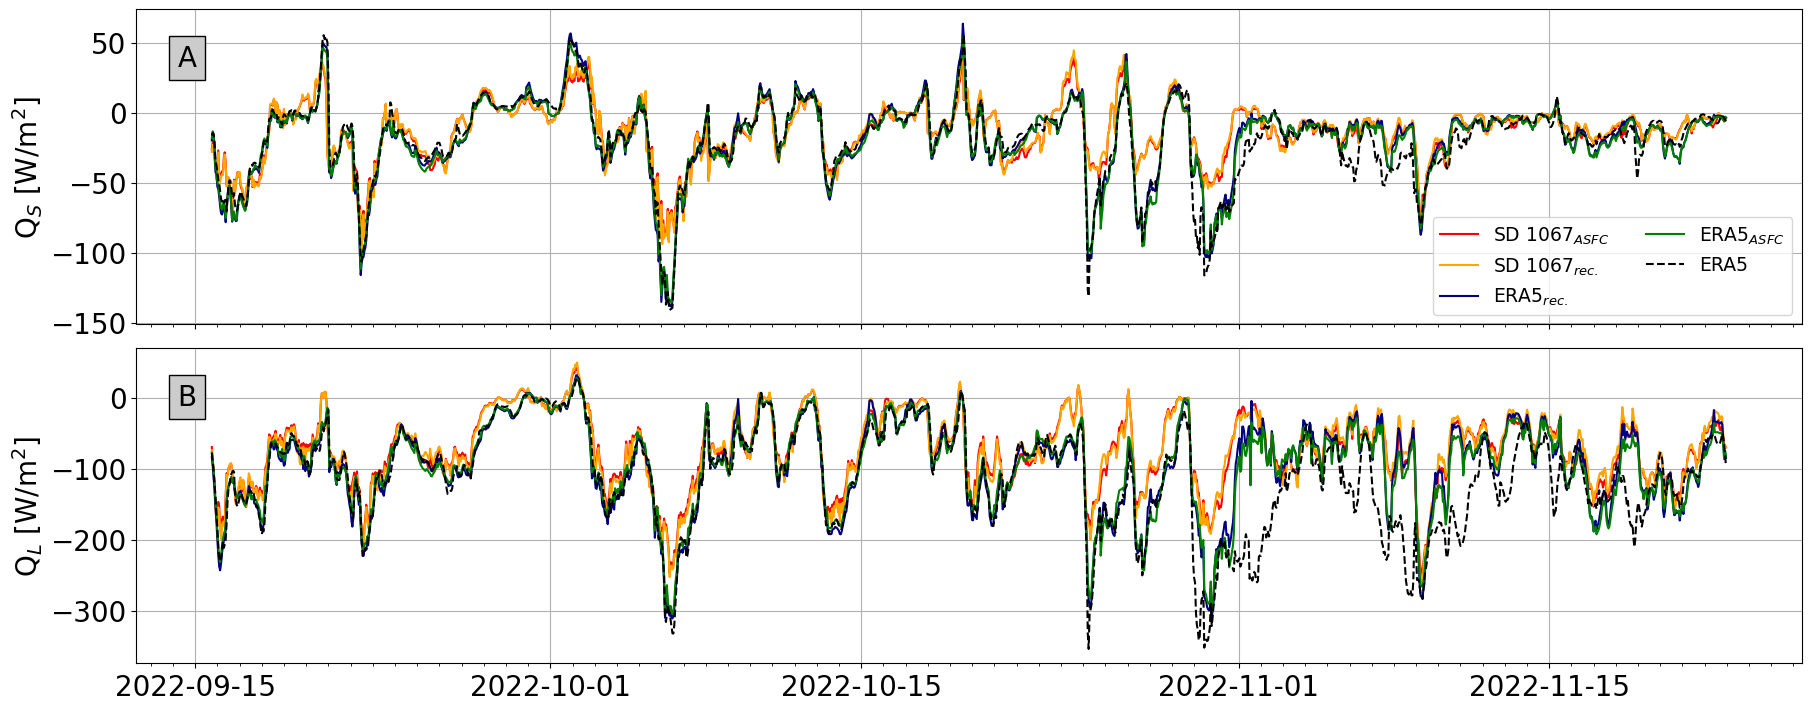

In [6]:
bajs=2
fig, ax=plt.subplots(bajs,1, figsize=[18,7], sharex=True, constrained_layout=True)

ax[0].plot(dsadcpH.time, SD_ASFC.sensible, label='SD 1067$_{ASFC}$', c='red')
ax[0].plot(dsadcpH.time, rec_SD.shf_recomposed, label='SD 1067$_{rec.}$', c='orange')
ax[0].plot(dsadcpH.time, rec_ERA5.shf_recomposed, label='ERA5$_{rec.}$',c='navy')
ax[0].plot(dsadcpH.time, ERA5_ASFC.sensible, label='ERA5$_{ASFC}$',c='green')
ax[0].plot(dsadcpH.time, coloc4.sensible, label='ERA5',c='k', linestyle='--')
ax[0].set_ylabel('Q$_S$ [W/m$^2$]')

ax[1].plot(dsadcpH.time, SD_ASFC.latent, label='SD 1067$_{ASFC}$', c='red')
ax[1].plot(dsadcpH.time, rec_SD.lhf_recomposed, label='SD 1067$_{rec.}$', c='orange')
ax[1].plot(dsadcpH.time, rec_ERA5.lhf_recomposed, label='ERA5$_{rec.}$',c='navy')
ax[1].plot(dsadcpH.time, ERA5_ASFC.latent, label='ERA5$_{ASFC}$',c='green')
ax[1].plot(dsadcpH.time, coloc4.latent, label='ERA5',c='k', linestyle='--')

ax[1].set_ylabel('Q$_L$ [W/m$^2$]')


ax[0].legend(fontsize=13.5, ncols=2)
ax[0].xaxis.set_minor_locator(mdates.DayLocator())

bbox = dict(boxstyle="square", fc="0.8")


ax[0].annotate('A', xy=(0.025,0.82), xycoords='axes fraction', bbox=bbox)
ax[1].annotate('B', xy=(0.025,0.82), xycoords='axes fraction', bbox=bbox)


for i in np.arange(bajs):
    ax[i].grid()
#    ax[i].legend()

plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/final_figs/Flux_ts.png')

# 8.2 Upscaling

Write code for create mean and fluc variables, for-loop per day. Input in a ds, plot for each tays with fluctuations and create animation

ostia sst input data?

# CAREFUL TO RUN NEXT CELLS IF NOT NECESSARY, VERY TIME CONSUMING

## For loop, run to create anomaly and bar grid for ERA5 data. OSTIA SST

In [29]:
rec_ds=ERA5big.copy().drop(['u10','v10','d2m','t2m','msl','dwlw','dwsw','msdwswrfcs','mslhf','msshf','sst','WIND_CORR10','rh','msdwlwrfcs'])
arr = np.ndarray(ERA5big.sst.shape) * np.nan

rec_ds['t_term']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['u_term_t']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['q_term']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['u_term_q']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['lhf_coeffs']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['shf_coeffs']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['cov_term_t']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['cov_term_q']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['lhf_fluc']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['shf_fluc']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['lhf_mean']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['shf_mean']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['lhf_recomposed']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['shf_recomposed']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))

In [31]:
for i in tqdm(np.arange(len(ERA5big.latitude))):
    
    for tt in np.arange(len(ERA5big.longitude)):
        e5=ERA5big.isel(latitude=i, longitude=tt)

        lat=e5.latitude.values
        lon=e5.longitude.values
        SST= e5.sst.values #e5.sst.values #ostia.sel(latitude=lat, longitude=lon, method='nearest').sst.values
        
        if  np.isfinite(SST.mean()):
            hum1=e5.rh.values
            
            spd= e5.WIND_CORR10.values#relative windpeed
            T= e5.t2m.values #seasurface temperature in kelvin. Will convert iff less than 200
            hum= ['rh', hum1 ] #chose rh, spec hum or dew point temp.
            P= e5.msl.values/100 #air pressure in hPA
            SST_fl ='skin' #string, 'bulk' or 'skin' for input
            meth= 'C35' #string, choose method of calcultion
            lat= np.zeros(len(spd))+e5.latitude.values #latitude
            hin=([10, 2, 2])  #sensor heights in m, 3x1 same order as output 
            hout=10 #output height, default is 10m
            Rl=e5.dwlw.values#longwave dwn radiation
            Rs= e5.dwsw.values # shortwave dwn radiation
            cskin= 0 #0 cool skin adj off
            skin='C35' #'C35' #string "C35", "ecmwf" or "Beljaars"
            wl=0 #warm layer off 0 (default)
            gust= None# [x,beta,zi,ustbj] #Check documentation
            qmeth= 'Buck2' #string, saturation evaporation method
            tol= None #float, tolerance limits for fluxes and heights, check documentation
            maxiter= 30 #number fo iterations
            out= 0 #int, set 0 to set points thathave not converged
            out_var= None #str, define pandas arrayod variables for output. There i a default for cskin and gust off. Check documentation
            L=None #str, M-O definition option. 'tsrv' is default
            
            ASFC=AirSeaFluxCode(spd, T, SST, SST_fl, meth, lat=lat, hum=hum, P=P,
                               hin=hin, hout=hout, Rl=Rl, Rs=Rs, cskin=cskin, skin=skin, wl=wl,
                               gust=gust, qmeth=qmeth, tol=tol, maxiter=maxiter, out=out,
                               out_var=out_var, L=L)
            
            u = ASFC.uref #ASFC['usr']/np.sqrt(ASFC['cd'])
            t = ASFC['tsr']*np.sqrt(ASFC['cd'])/ASFC['ct']
            rho = ASFC['rho']
            cp = ASFC['cp']
            ct = ASFC['ct']
            lv = ASFC['lv']
            q = ASFC['qsr']*np.sqrt(ASFC['cd'])/ASFC['cq']
            cq= ASFC['cq']
            
            u_mean = np.mean(u)
            t_mean = np.mean(t)
            q_mean = np.mean(q)
            
            u_fluc = u - u_mean
            t_fluc = t - t_mean
            q_fluc = q - q_mean
            
            
            t_term = u_mean*t_fluc
            u_term_t = t_mean*u_fluc
            q_term = u_mean*q_fluc
            u_term_q = q_mean*u_fluc
            
            #lhf_coeffs=rho*cq*lv
            #shf_coeffs=rho*cp*ct
            
            lhf_coeffs=rho.mean()*cq.mean()*lv.mean()
            shf_coeffs=rho.mean()*cp.mean()*ct.mean()
            
            cov_term_t = u_fluc*t_fluc - np.mean(u_fluc*t_fluc)
            cov_term_q = u_fluc*q_fluc - np.mean(u_fluc*q_fluc)
            
            lhf_fluc = lhf_coeffs*(q_term + u_term_q + cov_term_q) 
            shf_fluc = shf_coeffs*(t_term + u_term_t + cov_term_t) 
            
            lhf_mean = np.zeros(len(q))+np.nanmean(q*u)*lhf_coeffs #np.mean(ASFC['latent'])
            shf_mean = np.zeros(len(q))+np.nanmean(t*u)*shf_coeffs #np.mean(ASFC['sensible'])
            
            lhf_recomposed = lhf_mean + lhf_fluc
            shf_recomposed = shf_mean + shf_fluc
            
            
            #variables=['t_term', 'u_term_t', 'q_term', 'u_term_q','lhf_coeffs', 'shf_coeffs', 'cov_term_t', 'cov_term_q', 'lhf_fluc', 'shf_fluc', 'lhf_mean', 'shf_mean', 'lhf_recomposed','shf_recomposed' ]

            
            # ERA5bigtest['new_var'] = xr.DataArray(arr,dims=('time','latitude','longitude'))
            rec_ds['t_term'][:,i,tt]=shf_coeffs* t_term
            rec_ds['u_term_t'][:,i,tt]= shf_coeffs* u_term_t
            rec_ds['q_term'][:,i,tt]= lhf_coeffs*q_term
            rec_ds['u_term_q'][:,i,tt]= lhf_coeffs*u_term_q
            rec_ds['lhf_coeffs'][:,i,tt]= lhf_coeffs
            rec_ds['shf_coeffs'][:,i,tt]= shf_coeffs
            rec_ds['cov_term_t'][:,i,tt]= shf_coeffs* cov_term_t
            rec_ds['cov_term_q'][:,i,tt]=lhf_coeffs*cov_term_q
            rec_ds['lhf_fluc'][:,i,tt]= lhf_fluc
            rec_ds['shf_fluc'][:,i,tt]=shf_fluc
            rec_ds['lhf_mean'][:,i,tt]=lhf_mean 
            rec_ds['shf_mean'][:,i,tt]=shf_mean
            rec_ds['lhf_recomposed'][:,i,tt]=lhf_recomposed 
            rec_ds['shf_recomposed'][:,i,tt]=shf_recomposed 

100%|███████████████████████████████████████████| 65/65 [04:27<00:00,  4.12s/it]


In [32]:
rec_ds.to_netcdf(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscaleERA5.nc')

#  IF FOR-LOOP NOT NECESSARY START HERE

### Open reconstructed dataset that was created with for-loop, ERA5 data

In [7]:
#rec_ds_ostia_coloc=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscaleOSTIA_coloc.nc')
rec_ds_ERA5=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscaleERA5.nc')
#rec_ds_ostia_regrid=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscaleOSTIA_regrid.nc')

Text(0.05, 0.88, 'G')

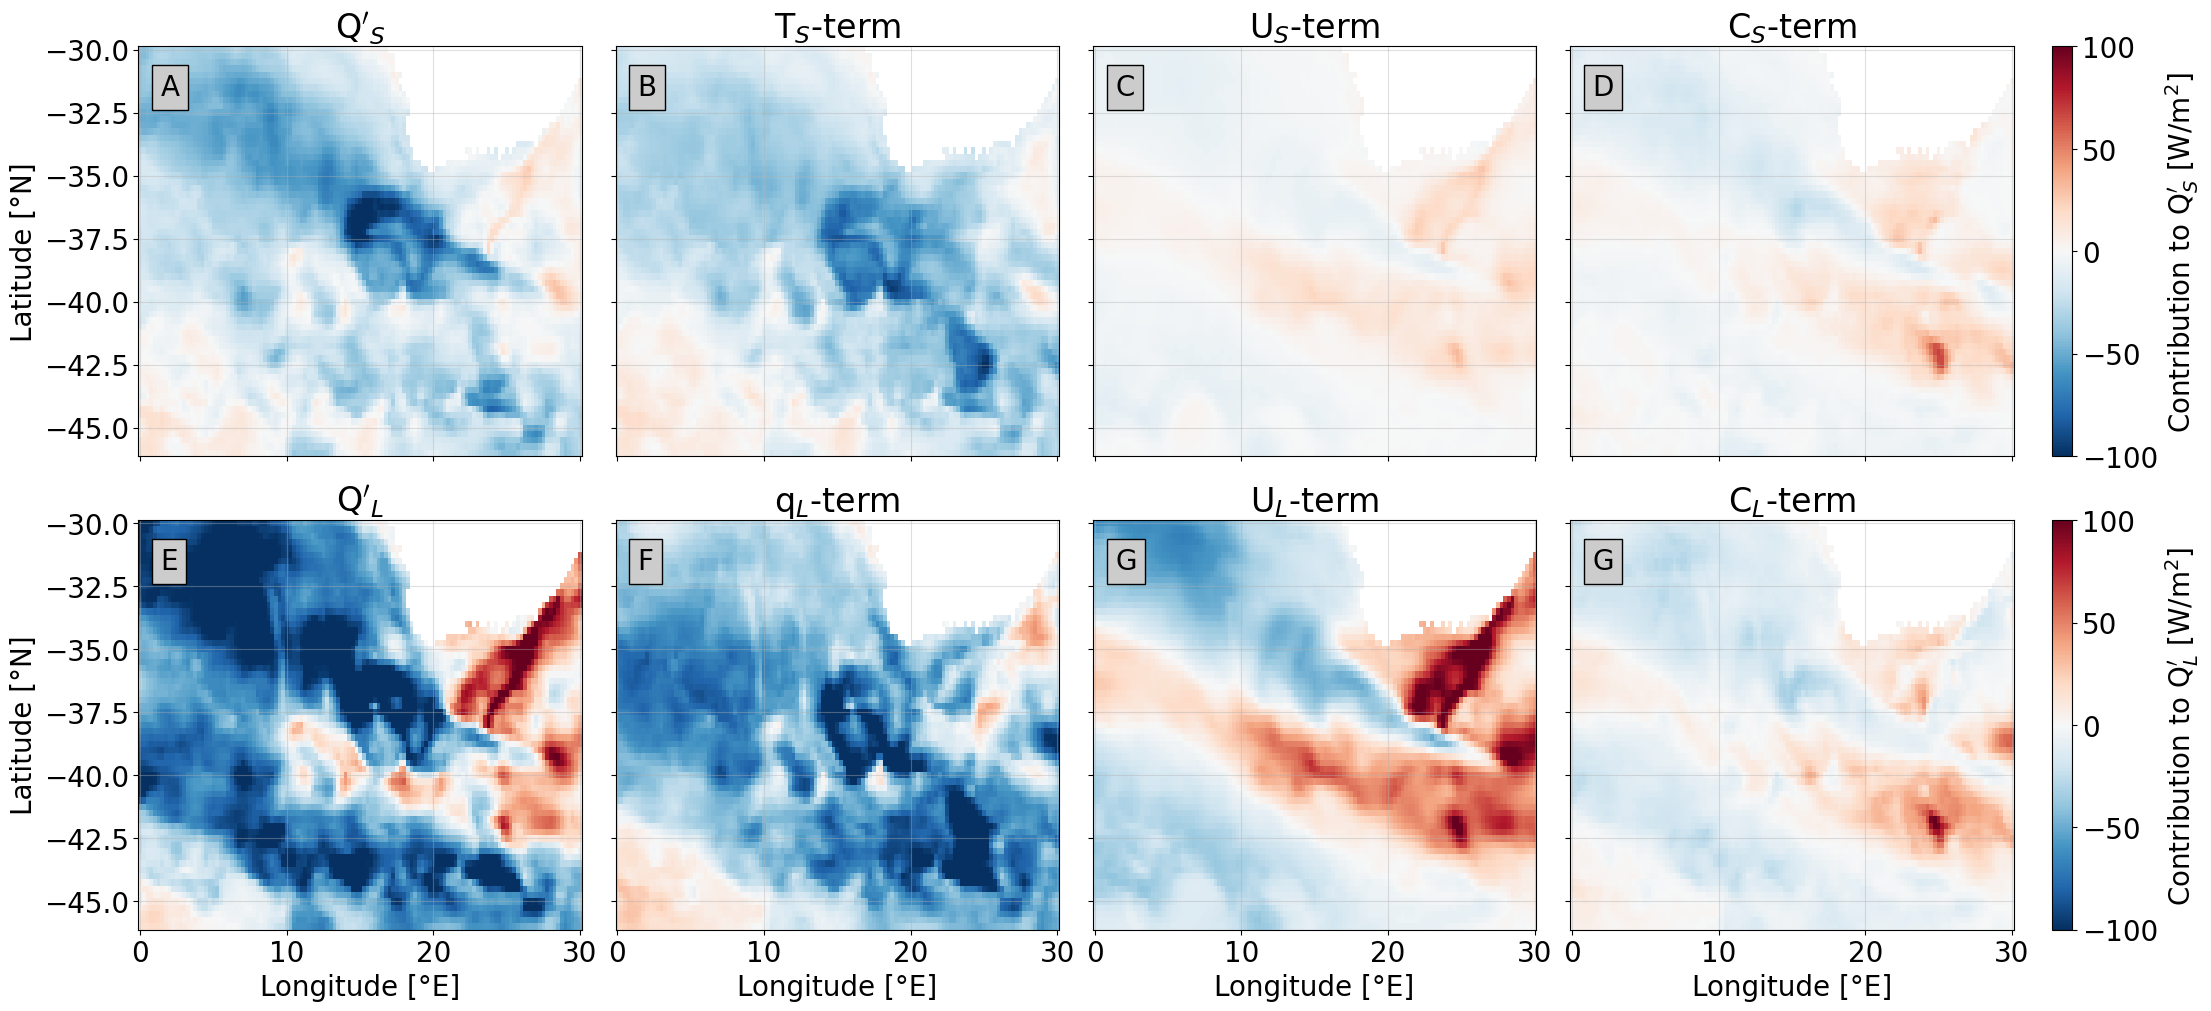

In [9]:
time=50
vmin_l=-100
vmax_l=100

vmin_s=vmin_l
vmax_s=vmax_l
cmap='RdBu_r'

rec_ds=rec_ds_ERA5


fig, ax=plt.subplots(2,4, figsize=[22,10], constrained_layout=True, sharey=True, sharex=True)

ax[0,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.shf_fluc.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )

ax[0,0+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.t_term.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
ax[0,1+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_t.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
cbar_s=ax[0,2+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_t.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
plt.colorbar(cbar_s, ax=ax[0,2+1], label='Contribution to Q$^\prime _{S}$ [W/m$^2$] ')


ax[1,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.lhf_fluc.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
ax[1,0+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.q_term.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
ax[1,1+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_q.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
cbar_l=ax[1,2+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_q.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
plt.colorbar(cbar_l, ax=ax[1,2+1], label='Contribution to Q$^\prime _{L}$ [W/m$^2$] ')


ax[0,0].set_title('Q$^\prime$$_S$')
ax[0,0+1].set_title('T$_S$-term')
ax[0,1+1].set_title('U$_S$-term')
ax[0,2+1].set_title('C$_S$-term')

ax[1,0].set_title('Q$^\prime$$_L$')
ax[1,0+1].set_title('q$_L$-term')
ax[1,1+1].set_title('U$_L$-term')
ax[1,2+1].set_title('C$_L$-term')
alpha=0.4

ax[0,0].grid(alpha=alpha)
ax[0,0+1].grid(alpha=alpha)
ax[0,1+1].grid(alpha=alpha)
ax[0,2+1].grid(alpha=alpha)

ax[1,0].grid(alpha=alpha)
ax[1,0+1].grid(alpha=alpha)
ax[1,1+1].grid(alpha=alpha)
ax[1,2+1].grid(alpha=alpha)


ax[1,0].set_xlabel('Longitude [°E]')
ax[1,0+1].set_xlabel('Longitude [°E]')
ax[1,1+1].set_xlabel('Longitude [°E]')
ax[1,2+1].set_xlabel('Longitude [°E]')

ax[0,0].set_ylabel('Latitude [°N]')
ax[1,0].set_ylabel('Latitude [°N]')



fig_labels=[['A','B','C','D'],['E','F','G','H']]

x=0.05
y=0.88

ax[0,0].annotate(fig_labels[0][0], xy=(x,y), xycoords='axes fraction', bbox=bbox)
ax[0,1].annotate(fig_labels[0][1], xy=(x,y), xycoords='axes fraction', bbox=bbox)
ax[0,2].annotate(fig_labels[0][2], xy=(x,y), xycoords='axes fraction', bbox=bbox)
ax[0,3].annotate(fig_labels[0][3], xy=(x,y), xycoords='axes fraction', bbox=bbox)

ax[1,0].annotate(fig_labels[1][0], xy=(x,y), xycoords='axes fraction', bbox=bbox)
ax[1,1].annotate(fig_labels[1][1], xy=(x,y), xycoords='axes fraction', bbox=bbox)
ax[1,2].annotate(fig_labels[1][2], xy=(x,y), xycoords='axes fraction', bbox=bbox)
ax[1,3].annotate(fig_labels[1][2], xy=(x,y), xycoords='axes fraction', bbox=bbox)

In [17]:
rec_ds

<xarray.Dataset>
Dimensions:         (longitude: 121, latitude: 65, time: 1638)
Coordinates:
  * longitude       (longitude) float32 0.0 0.25 0.5 0.75 ... 29.5 29.75 30.0
  * latitude        (latitude) float32 -30.0 -30.25 -30.5 ... -45.5 -45.75 -46.0
  * time            (time) datetime64[ns] 2022-09-15T18:00:00 ... 2022-11-22T...
Data variables: (12/14)
    t_term          (time, latitude, longitude) float64 ...
    u_term_t        (time, latitude, longitude) float64 ...
    q_term          (time, latitude, longitude) float64 ...
    u_term_q        (time, latitude, longitude) float64 ...
    lhf_coeffs      (time, latitude, longitude) float64 ...
    shf_coeffs      (time, latitude, longitude) float64 ...
    ...              ...
    lhf_fluc        (time, latitude, longitude) float64 ...
    shf_fluc        (time, latitude, longitude) float64 ...
    lhf_mean        (time, latitude, longitude) float64 ...
    shf_mean        (time, latitude, longitude) float64 ...
    lhf_recomposed  (time, latitude, longitude) float64 ...
    shf_recomposed  (time, latitude, longitude) float64 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-09 13:22:35 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [15]:
np.shape(rec_ds.lhf_fluc.isel(time=time).values[1])

(121,)

(array([[0., 6., 2., 0., 0., 0., 0., 0., 0., 0.],
        [0., 6., 3., 3., 0., 0., 0., 0., 0., 0.],
        [3., 1., 3., 0., 2., 3., 0., 0., 0., 0.],
        [3., 1., 0., 0., 2., 3., 4., 0., 0., 0.],
        [1., 4., 5., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 2., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 2., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 2., 2.]]),
 array([-118.36975569, -106.18032946,  -93.99090324,  -81.80147702,
         -69.6120508 ,  -57.42262458,  -45.23319835,  -33.04377213,
         -20.85434591,   -8.66491969,    3.52450653]),
 array([-36.17989771, -31.73779494, -27.29569217, -22.8535894 ,
        -18.41148664, -13.96938387,  -9.5272811 ,  -5.08517833,
         -0.64307556,   3.79902721,   8.24112998]),
 <matplotlib.collections.QuadMesh at 0x7f87361a0410>)

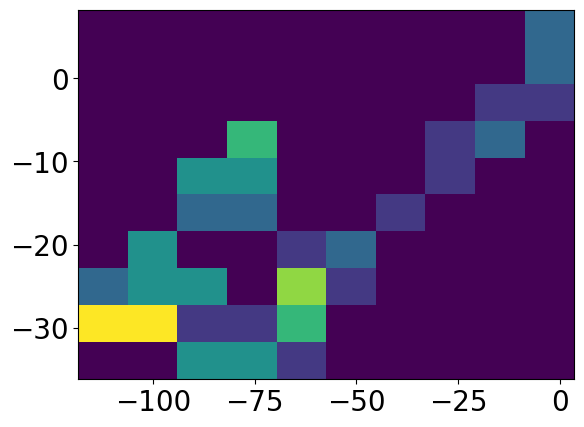

In [27]:
lat=1
msk=np.isfinite(rec_ds.lhf_fluc.isel(time=time)[lat])


plt.hist2d(rec_ds.lhf_fluc.isel(time=time)[lat].isel(longitude=msk), rec_ds.q_term.isel(time=time)[lat].isel(longitude=msk))


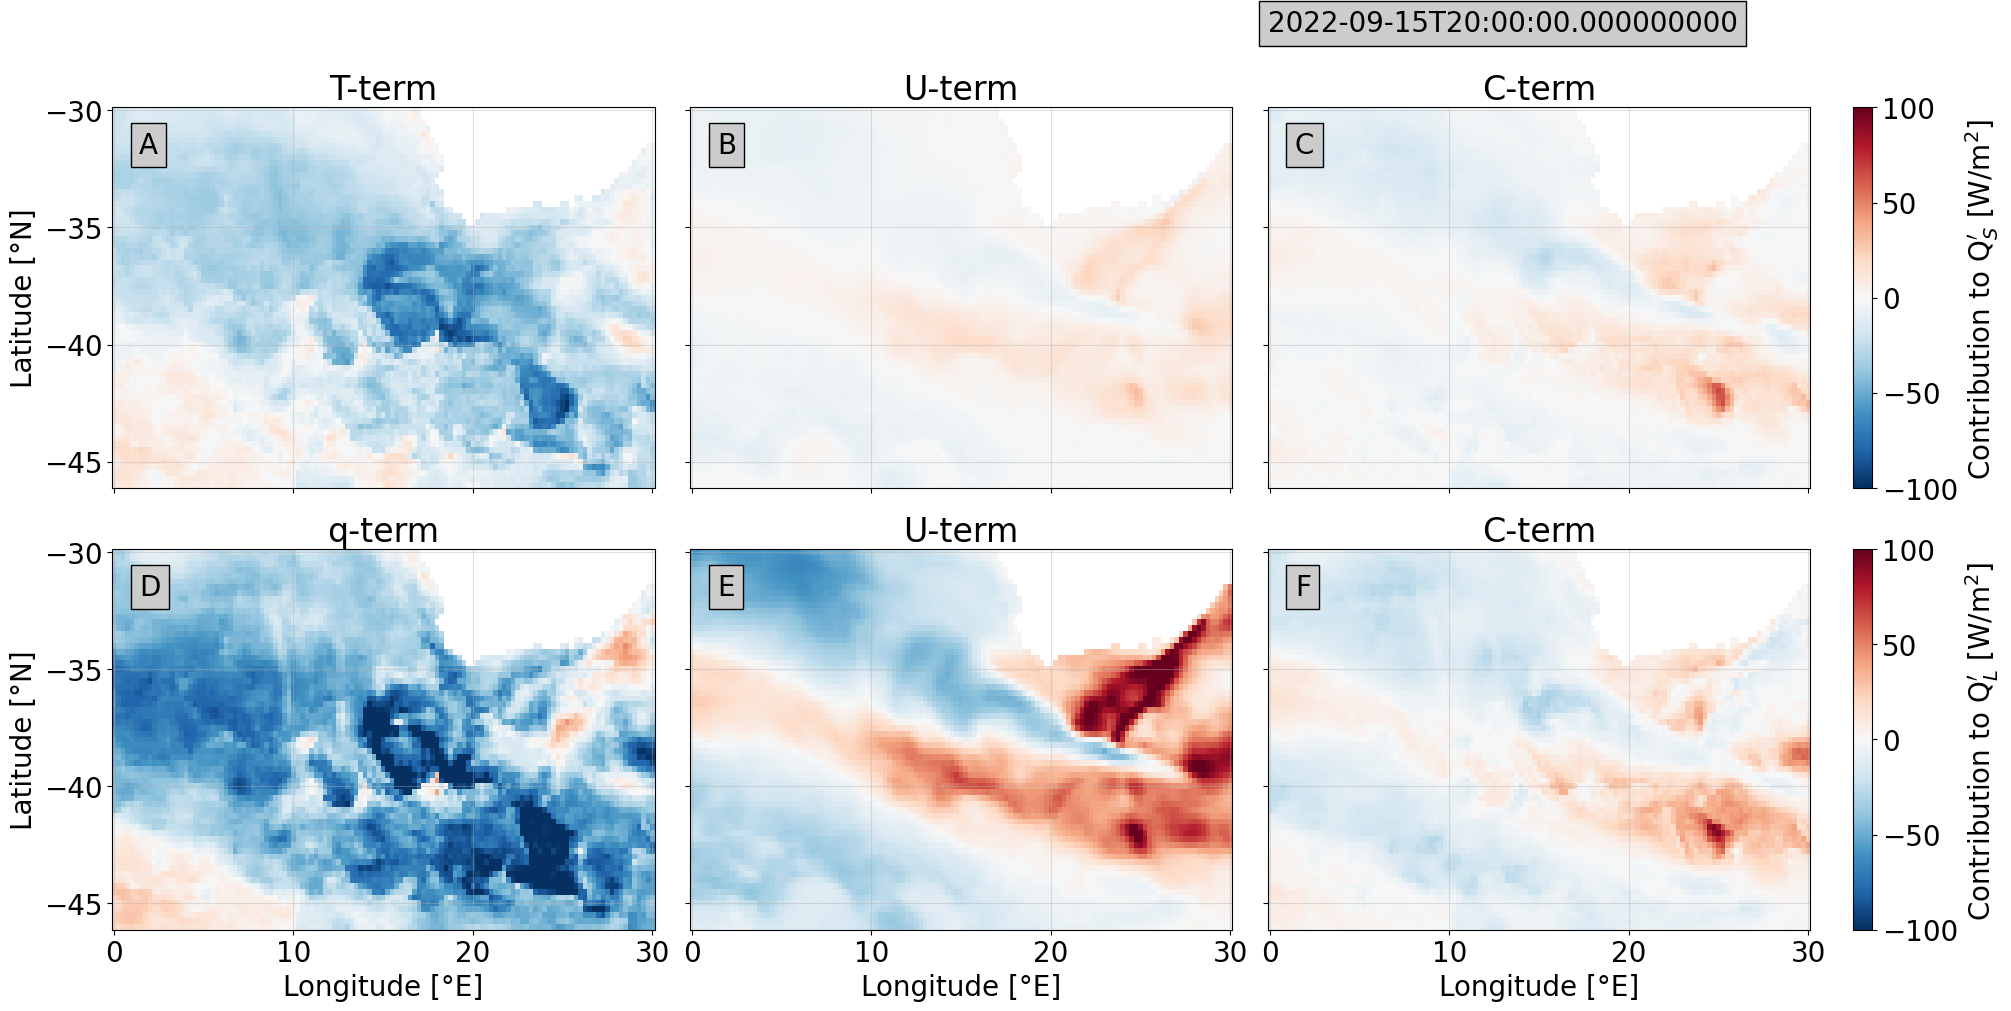

In [64]:
time=50
vmin_s=-100
vmin_l=-100
vmax_s=100
vmax_l=100
cmap='RdBu_r'

rec_ds=rec_ds_ostia_coloc


fig, ax=plt.subplots(2,3, figsize=[20,10], constrained_layout=True, sharey=True, sharex=True)

ax[0,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.t_term.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
ax[0,1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_t.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
cbar_s=ax[0,2].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_t.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
plt.colorbar(cbar_s, ax=ax[0,2], label='Contribution to Q$^\prime _{S}$ [W/m$^2$] ')

ax[1,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.q_term.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
ax[1,1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_q.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
cbar_l=ax[1,2].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_q.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
plt.colorbar(cbar_l, ax=ax[1,2], label='Contribution to Q$^\prime _{L}$ [W/m$^2$] ')

ax[0,0].set_title('T-term')
ax[0,1].set_title('U-term')
ax[0,2].set_title('C-term')

ax[1,0].set_title('q-term')
ax[1,1].set_title('U-term')
ax[1,2].set_title('C-term')

alpha=0.4

ax[0,0].grid(alpha=alpha)
ax[0,1].grid(alpha=alpha)
ax[0,2].grid(alpha=alpha)

ax[1,0].grid(alpha=alpha)
ax[1,1].grid(alpha=alpha)
ax[1,2].grid(alpha=alpha)



ax[1,0].set_xlabel('Longitude [°E]')
ax[1,1].set_xlabel('Longitude [°E]')
ax[1,2].set_xlabel('Longitude [°E]')

ax[0,0].set_ylabel('Latitude [°N]')
ax[1,0].set_ylabel('Latitude [°N]')


bbox = dict(boxstyle="square", fc="0.8")


fig_labels=[['A','B','C'],['D','E','F']]

ax[0,2].annotate(str(rec_ds.time[i].values), xy=(0, 1.2), xycoords='axes fraction', bbox=bbox)

x=0.05
y=0.88
for i in np.arange(3):
    ax[0,i].annotate(fig_labels[0][i], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    ax[1,i].annotate(fig_labels[1][i], xy=(x,y), xycoords='axes fraction', bbox=bbox)

Text(0, 0.5, 'Latitude [°N]')

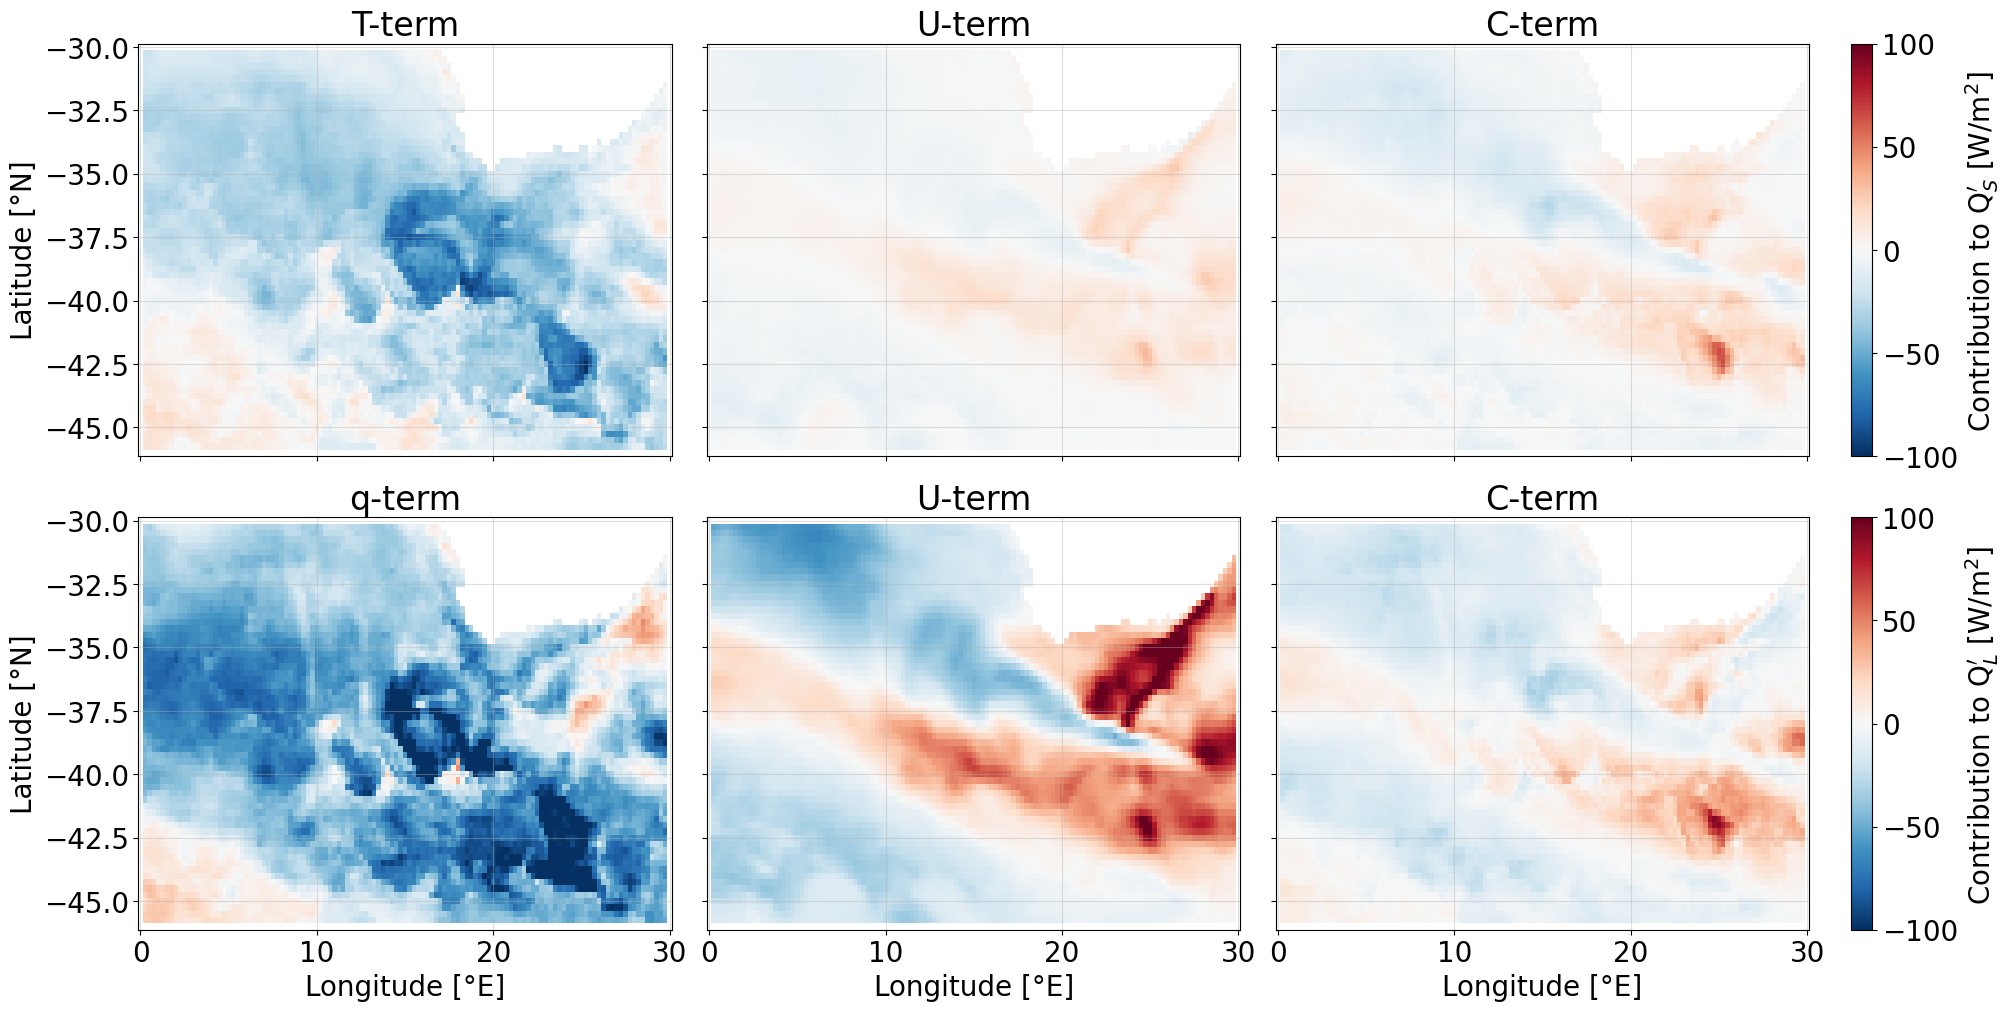

In [45]:
time=50
vmin_s=-100
vmin_l=-100
vmax_s=100
vmax_l=100
cmap='RdBu_r'

rec_ds=rec_ds_ostia_regrid


fig, ax=plt.subplots(2,3, figsize=[20,10], constrained_layout=True, sharey=True, sharex=True)

ax[0,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.t_term.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
ax[0,1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_t.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
cbar_s=ax[0,2].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_t.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
plt.colorbar(cbar_s, ax=ax[0,2], label='Contribution to Q$^\prime _{S}$ [W/m$^2$] ')

ax[1,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.q_term.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
ax[1,1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_q.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
cbar_l=ax[1,2].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_q.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
plt.colorbar(cbar_l, ax=ax[1,2], label='Contribution to Q$^\prime _{L}$ [W/m$^2$] ')

ax[0,0].set_title('T-term')
ax[0,1].set_title('U-term')
ax[0,2].set_title('C-term')

ax[1,0].set_title('q-term')
ax[1,1].set_title('U-term')
ax[1,2].set_title('C-term')

alpha=0.4

ax[0,0].grid(alpha=alpha)
ax[0,1].grid(alpha=alpha)
ax[0,2].grid(alpha=alpha)

ax[1,0].grid(alpha=alpha)
ax[1,1].grid(alpha=alpha)
ax[1,2].grid(alpha=alpha)



ax[1,0].set_xlabel('Longitude [°E]')
ax[1,1].set_xlabel('Longitude [°E]')
ax[1,2].set_xlabel('Longitude [°E]')

ax[0,0].set_ylabel('Latitude [°N]')
ax[1,0].set_ylabel('Latitude [°N]')

In [ ]:
labelS = ['T$_S$-term', 'U$_S$-term', 'C$_S$-term']
labelL = ['q$_L$-term', 'U$_L$-term', 'C$_L$-term']

In [59]:
rec_ds=rec_ds_ERA5 #Choose dataset

vmin_l=-100
vmax_l=100

vmin_s=vmin_l
vmax_s=vmax_l

cmap='RdBu_r'
alpha=0.4


for i in tqdm(np.arange(len(ERA5big.time))):
    time=i

    
    fig, ax=plt.subplots(2,4, figsize=[22,10], constrained_layout=True, sharey=True, sharex=True)
    
    ax[0,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.shf_fluc.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
    ax[0,0+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.t_term.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
    ax[0,1+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_t.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
    cbar_s=ax[0,2+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_t.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
    plt.colorbar(cbar_s, ax=ax[0,2+1], label='Contribution to Q$^\prime _{S}$ [W/m$^2$] ')
    
    
    ax[1,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.lhf_fluc.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
    ax[1,0+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.q_term.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
    ax[1,1+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_q.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
    cbar_l=ax[1,2+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_q.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
    plt.colorbar(cbar_l, ax=ax[1,2+1], label='Contribution to Q$^\prime _{L}$ [W/m$^2$] ')
    
    ax[0,0].set_title('Q$^\prime$$_S$')
    ax[0,0+1].set_title('T$_S$-term')
    ax[0,1+1].set_title('U$_S$-term')
    ax[0,2+1].set_title('C$_S$-term')
    
    ax[1,0].set_title('Q$^\prime$$_L$')
    ax[1,0+1].set_title('q$_L$-term')
    ax[1,1+1].set_title('U$_L$-term')
    ax[1,2+1].set_title('C$_L$-term')
    alpha=0.4
    
    ax[0,0].grid(alpha=alpha)
    ax[0,0+1].grid(alpha=alpha)
    ax[0,1+1].grid(alpha=alpha)
    ax[0,2+1].grid(alpha=alpha)
    
    ax[1,0].grid(alpha=alpha)
    ax[1,0+1].grid(alpha=alpha)
    ax[1,1+1].grid(alpha=alpha)
    ax[1,2+1].grid(alpha=alpha)
    
    
    ax[1,0].set_xlabel('Longitude [°E]')
    ax[1,0+1].set_xlabel('Longitude [°E]')
    ax[1,1+1].set_xlabel('Longitude [°E]')
    ax[1,2+1].set_xlabel('Longitude [°E]')
    
    ax[0,0].set_ylabel('Latitude [°N]')
    ax[1,0].set_ylabel('Latitude [°N]')


    bbox = dict(boxstyle="square", fc="0.8")
    ax[0,2].annotate(str(rec_ds.time[i].values), xy=(0, 1.2), xycoords='axes fraction', bbox=bbox)

    fig_labels=[['A','B','C','D'],['E','F','G','H']]

    x=0.05
    y=0.88
    
    ax[0,0].annotate(fig_labels[0][0], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    ax[0,1].annotate(fig_labels[0][1], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    ax[0,2].annotate(fig_labels[0][2], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    ax[0,3].annotate(fig_labels[0][3], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    
    ax[1,0].annotate(fig_labels[1][0], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    ax[1,1].annotate(fig_labels[1][1], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    ax[1,2].annotate(fig_labels[1][2], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    ax[1,3].annotate(fig_labels[1][2], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    

    

    plt.savefig(pathlib.Path('.').absolute().parent/ f'MTmichaela/ani_fig/pic_{i:04}.png')
    
    plt.close(fig)

100%|███████████████████████████████████████████████████████████████████████████| 1638/1638 [27:30<00:00,  1.01s/it]


In [60]:
import moviepy.video.io.ImageSequenceClip
image_folder=pathlib.Path('.').absolute().parent/ 'MTmichaela/ani_fig'
fps=8

image_files = [os.path.join(image_folder,img)
               for img in np.sort(os.listdir(image_folder))
               if img.endswith(".png")]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('terms.mp4')

Moviepy - Building video terms.mp4.
Moviepy - Writing video terms.mp4



Moviepy - Done !
Moviepy - video ready terms.mp4
